In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error
import xgboost as xgb
from my_functions import map_home, numeric_houses, dummy_houses, quality_multiplication, test_col_matcher
# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Read in the labaled data

In [2]:
df = pd.read_csv('../datasets/train.csv')
df.columns =df.columns.str.lower().str.replace(' ','')

#### Taking a peek at the missing values in two ways

80 Columns and the target (sale price). df['alley] is almost all missing and I sense there are different logical reasons for the rates of missing values. There may be no way to describe quality of an amenity that a house does not have! 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2051 non-null   int64  
 1   pid            2051 non-null   int64  
 2   mssubclass     2051 non-null   int64  
 3   mszoning       2051 non-null   object 
 4   lotfrontage    1721 non-null   float64
 5   lotarea        2051 non-null   int64  
 6   street         2051 non-null   object 
 7   alley          140 non-null    object 
 8   lotshape       2051 non-null   object 
 9   landcontour    2051 non-null   object 
 10  utilities      2051 non-null   object 
 11  lotconfig      2051 non-null   object 
 12  landslope      2051 non-null   object 
 13  neighborhood   2051 non-null   object 
 14  condition1     2051 non-null   object 
 15  condition2     2051 non-null   object 
 16  bldgtype       2051 non-null   object 
 17  housestyle     2051 non-null   object 
 18  overallq

Divide and conquer! I found that most columns

In [4]:
# Only the features missing data in order of most missing to least missing
features = list(df.columns)
missing_vals= [(df[features[i]].isna().mean(),features[i])for i in range(80) if df[features[i]].isna().mean() > 0]
missing_vals.sort(key=lambda pair: pair[0], reverse= True)
missing_vals[:10] 

[(0.9956118966357874, 'poolqc'),
 (0.9683081423695759, 'miscfeature'),
 (0.931740614334471, 'alley'),
 (0.8049731838127743, 'fence'),
 (0.48756704046806437, 'fireplacequ'),
 (0.16089712335446124, 'lotfrontage'),
 (0.05558264261335934, 'garageyrblt'),
 (0.05558264261335934, 'garagefinish'),
 (0.05558264261335934, 'garagequal'),
 (0.05558264261335934, 'garagecond')]

In [5]:
missing_num = len(missing_vals)
# round to 4 places
missing_vals = [(round(missing_vals[i][0],4),missing_vals[i][1]) for i in range(missing_num)] 
# what are the data types of the missing features lets put that in the list
missing_vals_types = [(missing_vals[i][0],missing_vals[i][1],df[missing_vals[i][1]].dtype) for i in range(missing_num)]
# spliting this list in two for the two types of missing data
missing_vals_numeric = [missing_vals_types[i] for i in range(missing_num) if missing_vals_types[i][2] != 'object']
missing_vals_object = [missing_vals_types[i] for i in range(missing_num) if missing_vals_types[i][2] == 'object']


In [6]:
missing_vals_numeric

[(0.1609, 'lotfrontage', dtype('float64')),
 (0.0556, 'garageyrblt', dtype('float64')),
 (0.0107, 'masvnrarea', dtype('float64')),
 (0.001, 'bsmtfullbath', dtype('float64')),
 (0.001, 'bsmthalfbath', dtype('float64')),
 (0.0005, 'bsmtfinsf1', dtype('float64')),
 (0.0005, 'bsmtfinsf2', dtype('float64')),
 (0.0005, 'bsmtunfsf', dtype('float64')),
 (0.0005, 'totalbsmtsf', dtype('float64')),
 (0.0005, 'garagecars', dtype('float64')),
 (0.0005, 'garagearea', dtype('float64'))]

In [7]:
missing_vals_object

[(0.9956, 'poolqc', dtype('O')),
 (0.9683, 'miscfeature', dtype('O')),
 (0.9317, 'alley', dtype('O')),
 (0.805, 'fence', dtype('O')),
 (0.4876, 'fireplacequ', dtype('O')),
 (0.0556, 'garagefinish', dtype('O')),
 (0.0556, 'garagequal', dtype('O')),
 (0.0556, 'garagecond', dtype('O')),
 (0.0551, 'garagetype', dtype('O')),
 (0.0283, 'bsmtexposure', dtype('O')),
 (0.0273, 'bsmtfintype2', dtype('O')),
 (0.0268, 'bsmtqual', dtype('O')),
 (0.0268, 'bsmtcond', dtype('O')),
 (0.0268, 'bsmtfintype1', dtype('O')),
 (0.0107, 'masvnrtype', dtype('O'))]

What do these columns look like?

In [8]:
# lets look at the numeric data first
# dataframe of the numeric data columns
df_numeric = df[[missing_vals_numeric[i][1] for i in range(len(missing_vals_numeric))]]
df_numeric.describe()

,lotfrontage,garageyrblt,masvnrarea,bsmtfullbath,bsmthalfbath,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,garagecars,garagearea
count,1721.000000,1937.000000,2029.000000,2049.000000,2049.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000
mean,69.055200,1978.707796,99.695909,0.427526,0.063446,442.300488,47.959024,567.728293,1057.987805,1.776585,473.671707
std,23.260653,25.441094,174.963129,0.522673,0.251705,461.204124,165.000901,444.954786,449.410704,0.764537,215.934561
min,21.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,1961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.000000,793.000000,1.000000,319.000000
50%,68.000000,1980.000000,0.000000,0.000000,0.000000,368.000000,0.000000,474.500000,994.500000,2.000000,480.000000
75%,80.000000,2002.000000,161.000000,1.000000,0.000000,733.750000,0.000000,811.000000,1318.750000,2.000000,576.000000
max,313.000000,2207.000000,1600.000000,3.000000,2.000000,5644.000000,1474.000000,2336.000000,6110.000000,5.000000,1418.000000


In [9]:
# make notebook display all columns
pd.set_option('display.max_columns', None)

In [10]:
# what is going on with the garage year built
df[df['garageyrblt'] > 2010]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
1699,2261,916384070,20,RL,68.0,8298,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,VinylSd,VinylSd,NaN,NaN,Gd,TA,PConc,Gd,TA,Av,GLQ,583.0,Unf,0.0,963.0,1546.0,GasA,Ex,Y,SBrkr,1564,0,0,1564,0.0,0.0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,2207.0,RFn,2.0,502.0,TA,TA,Y,132,0,0,0,0,0,NaN,NaN,NaN,0,9,2007,New,267300


In [11]:
# that should be 2007 not 2207
df[df['garageyrblt'] == 2207]['garageyrblt'] = 2007

In [12]:
# is something weird about the basements in iowa?
# basements more than 2 std dev from the mean
df[df['totalbsmtsf'] > 2000]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
30,380,527355150,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,1104.0,Unf,0.0,1420.0,2524.0,GasA,TA,Y,SBrkr,2524,0,0,2524,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Gd,Attchd,1981.0,Fin,2.0,542.0,TA,TA,Y,474,120,0,0,0,0,NaN,MnPrv,NaN,0,7,2009,WD,278000
41,2383,528110050,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,465000
81,367,527214050,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,748.0,Ex,TA,PConc,Ex,TA,No,GLQ,1904.0,Unf,0.0,312.0,2216.0,GasA,Ex,Y,SBrkr,2234,0,0,2234,1.0,0.0,2,0,1,1,Ex,9,Typ,1,Gd,Attchd,2009.0,Fin,3.0,1166.0,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,501837
199,448,528166060,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,56.0,Unf,0.0,2336.0,2392.0,GasA,Ex,Y,SBrkr,2392,0,0,2392,0.0,0.0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003.0,Fin,3.0,968.0,TA,TA,Y,248,105,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,386250
222,2323,527146135,160,RL,68.0,13108,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,8,5,1994,1994,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,2062.0,2062.0,GasA,Ex,Y,SBrkr,2079,608,0,2687,0.0,0.0,2,1,4,1,Gd,9,Typ,0,NaN,Attchd,1994.0,Fin,2.0,618.0,TA,TA,Y,168,12,0,0,0,0,NaN,NaN,NaN,0,12,2006,WD,270000
286,960,916382100,20,RL,113.0,13438,Pave,NaN,IR1,HLS,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,9,5,2008,2008,Gable,CompShg,CemntBd,CmentBd,Stone,246.0,Ex,TA,CBlock,Ex,TA,Gd,GLQ,1758.0,Unf,0.0,432.0,2190.0,GasA,Ex,Y,SBrkr,2036,0,0,2036,1.0,0.0,2,0,3,1,Ex,9,Typ,1,Ex,Attchd,2008.0,Fin,3.0,780.0,TA,TA,Y,90,154,0,0,0,0,NaN,NaN,NaN,0,7,2009,WD,410000
328,1773,528366050,20,RL,NaN,12692,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,5,1992,1993,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1231.0,Unf,0.0,1969.0,3200.0,GasA,Ex,Y,SBrkr,3228,0,0,3228,1.0,0.0,3,0,4,1,Gd,10,Typ,1,Gd,Attchd,1992.0,RFn,2.0,546.0,TA,TA,Y,264,75,291,0,0,0,NaN,NaN,NaN,0,5,2007,WD,430000
359,1106,528363110,20,RL,91.0,10437,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,6,1995,1995,Hip,CompShg,MetalSd,MetalSd,BrkFace,660.0,Gd,Gd,PConc,Gd,TA,Gd,GLQ,1696.0,Unf,0.0,413.0,2109.0,GasA,Ex,Y,SBrkr,2113,0,0,2113,1.0,0.0,2,1,2,1,Gd,7,Typ,1,TA,Attchd,1995.0,Fin,3.0,839.0,TA,TA,Y,236,46,0,0,0,0,NaN,NaN,NaN,0,8,2008,WD,350000
378,1614,526355170,20,RL,95.0,13651,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,6,1973,1973,Gable,CompShg,Plywood,Plywood,BrkFace,1115.0,TA,Gd,CBlock,Gd,TA,Gd,ALQ,1880.0,Unf,0.0,343.0,2223.0,GasA,Ex,Y,SBrkr,2223,0,0,2223,1.0,0.0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1973.0,Fin,2.0,516.0,TA,TA,Y,300,0,0,0,0,0,NaN,NaN,NaN,0,2,2007,WD,2

In [13]:
# are these housees that have basements or not? they seem to all match square foot with the first floor square foot
df[(df['totalbsmtsf'] > 2000) & (df['totalbsmtsf'] == df['1stflrsf'])]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
30,380,527355150,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,PosN,Norm,1Fam,1Story,8,5,1981,1981,Hip,WdShngl,BrkFace,BrkFace,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,1104.0,Unf,0.0,1420.0,2524.0,GasA,TA,Y,SBrkr,2524,0,0,2524,1.0,0.0,2,1,4,1,Gd,9,Typ,1,Gd,Attchd,1981.0,Fin,2.0,542.0,TA,TA,Y,474,120,0,0,0,0,NaN,MnPrv,NaN,0,7,2009,WD,278000
41,2383,528110050,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,NaN,Ex,TA,PConc,Ex,Gd,Gd,GLQ,1386.0,Unf,0.0,690.0,2076.0,GasA,Ex,Y,SBrkr,2076,0,0,2076,1.0,0.0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2006.0,Fin,3.0,850.0,TA,TA,Y,216,229,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,465000
199,448,528166060,20,RL,103.0,13472,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2003,2003,Hip,CompShg,VinylSd,VinylSd,BrkFace,922.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,56.0,Unf,0.0,2336.0,2392.0,GasA,Ex,Y,SBrkr,2392,0,0,2392,0.0,0.0,2,0,3,1,Ex,8,Typ,1,Ex,Attchd,2003.0,Fin,3.0,968.0,TA,TA,Y,248,105,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,386250
378,1614,526355170,20,RL,95.0,13651,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,6,1973,1973,Gable,CompShg,Plywood,Plywood,BrkFace,1115.0,TA,Gd,CBlock,Gd,TA,Gd,ALQ,1880.0,Unf,0.0,343.0,2223.0,GasA,Ex,Y,SBrkr,2223,0,0,2223,1.0,0.0,2,0,3,1,TA,8,Typ,2,Gd,Attchd,1973.0,Fin,2.0,516.0,TA,TA,Y,300,0,0,0,0,0,NaN,NaN,NaN,0,2,2007,WD,244000
623,457,528176030,20,RL,100.0,14836,Pave,NaN,IR1,HLS,AllPub,Inside,Mod,NridgHt,Norm,Norm,1Fam,1Story,10,5,2004,2005,Hip,CompShg,CemntBd,CmentBd,Stone,730.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2146.0,Unf,0.0,346.0,2492.0,GasA,Ex,Y,SBrkr,2492,0,0,2492,1.0,0.0,2,1,2,1,Ex,8,Typ,1,Ex,Attchd,2004.0,Fin,3.0,949.0,TA,TA,Y,226,235,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,552000
1117,1764,528327060,20,RL,NaN,11400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,1Fam,1Story,10,5,2001,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,705.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1282.0,Unf,0.0,1351.0,2633.0,GasA,Ex,Y,SBrkr,2633,0,0,2633,1.0,0.0,2,1,2,1,Ex,8,Typ,2,Gd,Attchd,2001.0,RFn,3.0,804.0,TA,TA,Y,314,140,0,0,0,0,NaN,NaN,NaN,0,3,2007,WD,466500
1142,564,532478020,20,RL,NaN,15676,Pave,NaN,IR1,Low,AllPub,Inside,Gtl,Veenker,Norm,Norm,1Fam,1Story,8,8,1980,1980,Gable,CompShg,VinylSd,VinylSd,BrkFace,115.0,Gd,Gd,CBlock,Gd,Gd,Gd,ALQ,1733.0,Rec,92.0,189.0,2014.0,GasA,Gd,Y,SBrkr,2014,0,0,2014,1.0,0.0,2,0,2,1,Gd,6,Maj1,2,Gd,Attchd,1980.0,RFn,3.0,864.0,TA,TA,Y,462,0,0,255,0,0,NaN,MnPrv,NaN,0,4,2009,WD,275000
1248,1615,526355190,20,RL,95.0,15865,Pave,NaN,IR1,Lvl,AllPub,Inside,Mod,NAmes,Norm,Norm,1Fam,1Story,8,6,1970,1970,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,Gd,Gd,PConc,TA,Gd,Gd,ALQ,351.0,Rec,823.0,1043.0,2217.0,GasA,Ex,Y,SBrkr,2217,0,0,2217,1.0,0.0,2,0,4,1,Gd,8,Typ,1,TA,Attchd,1970.0,Unf,2.0,621.0,TA,TA,Y,81,207,0,0,224,0,NaN,NaN,NaN,0,10,2007,WD,268000
1561,2100,906378150,20,RL,93.0,10481,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2006,2007,Hip,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,Av,Unf,0.0,Unf,0.0,2140.0,2140.0,GasA,Ex,Y,SBrkr,2140,0,0,2140,0.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2006.0,Fin,3.0,894.0,TA,TA,Y,136,32,0,0,0,0,NaN,NaN,NaN,0,6

index 1885 led me down a rabbit hole of curiostiy. 

In [14]:
# distribution of the basement square foot and first floor square
# I literally think this house is a crime scene
# 908154195
df[df['pid'] == 908154195]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
1885,2181,908154195,20,RL,128.0,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010.0,Unf,0.0,1085.0,5095.0,GasA,Ex,Y,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008.0,Fin,3.0,1154.0,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,Elev,17000,10,2007,New,183850


In [15]:
# this house solde between median and mean sale price for this data set and it is enormous
df['saleprice'].mean(), df['saleprice'].median()


(181469.70160897123, 162500.0)

In [16]:
df[df['pid'] == 908154195][['saleprice', 'grlivarea','lotarea', 'garagearea', 'miscfeature', 'miscval', 'saletype']]


,saleprice,grlivarea,lotarea,garagearea,miscfeature,miscval,saletype
1885,183850,5095,39290,1154.0,Elev,17000,New


In [17]:
# ratios of the sale price, above ground square footage, lot area, garage area, misc value for their elevator compared to the medians
# side note in a 1-story home in Iowa - this house 
df[df['pid'] == 908154195][['saleprice', 'grlivarea', 'lotarea', 'garagearea', 'miscval']]/df[df['saletype'] == 'New'][['saleprice', 'grlivarea', 'lotarea', 'garagearea', 'miscval']].mean()

,saleprice,grlivarea,lotarea,garagearea,miscval
1885,0.658911,2.83396,3.555608,1.709994,160.0


In [18]:
# are there any other houses similar to this one? Enormmous new, good condition and paradoxically cheap? I am sure there is a reason but doubt it can be determined from the data we have
# houses with similar lot area and above ground square footage
df[(df['grlivarea'] > 4000) & (df['lotarea'] >5000)][['pid','saleprice', 'grlivarea', 'lotarea', 'garagearea', 'miscval', 'saletype']]

,pid,saleprice,grlivarea,lotarea,garagearea,miscval,saletype
960,908154235,160000,5642,63887,1418.0,0,New
1885,908154195,183850,5095,39290,1154.0,17000,New


In [19]:
# ratios with neighborhood median for the other absurdly cheap house?
df[df['pid'] == 908154235][['saleprice', 'grlivarea', 'lotarea', 'garagearea', 'miscval']]/df[(df['neighborhood'] == 'Edwards') &(df['saletype']=='New') ][['saleprice', 'grlivarea', 'lotarea', 'garagearea', 'miscval']].mean()

,saleprice,grlivarea,lotarea,garagearea,miscval
960,1.0018,1.744859,2.214684,1.608166,0.0


In [20]:
# drop them from the data set -908154235, 908154195
df = df[df['pid'] != 908154235]
df = df[df['pid'] != 908154195]

In [21]:
# most expensive houses here?
df[df['saleprice'] > 600000]

,id,pid,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremod/add,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,saleprice
1671,45,528150070,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188.0,Unf,0.0,142.0,2330.0,GasA,Ex,Y,SBrkr,2364,0,0,2364,1.0,0.0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3.0,820.0,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,611657


In [22]:
# lets look at the object data
# dataframe of the object data columns
df_object = df[[missing_vals_object[i][1] for i in range(len(missing_vals_object))]]
# show the value counts for each column
for i in range(len(df_object.columns)):
    print(df_object.columns[i])
    print(df_object[df_object.columns[i]].value_counts())
    print('\n')

poolqc
Gd    3
Fa    2
TA    2
Ex    1
Name: poolqc, dtype: int64


miscfeature
Shed    56
Gar2     4
Othr     3
TenC     1
Name: miscfeature, dtype: int64


alley
Grvl    85
Pave    55
Name: alley, dtype: int64


fence
MnPrv    227
GdPrv     83
GdWo      80
MnWw      10
Name: fence, dtype: int64


fireplacequ
Gd    521
TA    407
Fa     59
Po     31
Ex     31
Name: fireplacequ, dtype: int64


garagefinish
Unf    849
RFn    579
Fin    507
Name: garagefinish, dtype: int64


garagequal
TA    1830
Fa      82
Gd      18
Ex       3
Po       2
Name: garagequal, dtype: int64


garagecond
TA    1866
Fa      47
Gd      12
Po       8
Ex       2
Name: garagecond, dtype: int64


garagetype
Attchd     1211
Detchd      536
BuiltIn     132
Basment      27
2Types       19
CarPort      11
Name: garagetype, dtype: int64


bsmtexposure
No    1339
Av     288
Gd     201
Mn     163
Name: bsmtexposure, dtype: int64


bsmtfintype2
Unf    1747
Rec      80
LwQ      60
BLQ      48
ALQ      35
GLQ      23
Name: bs

In [23]:
# what about the columns without missing values? what do they look like? Are there any major issues with the data? Easy fixes?
# dataframe of the columns without missing values
df_no_missing = df.drop([missing_vals[i][1] for i in range(len(missing_vals))], axis=1)

In [24]:
# what are the columns that are not numeric? lets look at their value counts
# for each non numeric columns, value counts
for i in range(len(df_no_missing.columns)):
    if df_no_missing[df_no_missing.columns[i]].dtype == 'object':
        print(df_no_missing.columns[i])
        print(df_no_missing[df_no_missing.columns[i]].value_counts())
        print('\n')

mszoning
RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: mszoning, dtype: int64


street
Pave    2042
Grvl       7
Name: street, dtype: int64


lotshape
Reg    1295
IR1     691
IR2      55
IR3       8
Name: lotshape, dtype: int64


landcontour
Lvl    1843
HLS      85
Bnk      78
Low      43
Name: landcontour, dtype: int64


utilities
AllPub    2047
NoSeWa       1
NoSewr       1
Name: utilities, dtype: int64


lotconfig
Inside     1502
Corner      347
CulDSac     131
FR2          60
FR3           9
Name: lotconfig, dtype: int64


landslope
Gtl    1951
Mod      88
Sev      10
Name: landslope, dtype: int64


neighborhood
NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmn

utilities: NoSeWa, NoSewr only appear once each. They cannot be accounted for by the models. This should be safe to drop
electrical: mix 1 only - drop? Not for now

In [25]:
# anything else wierd about numeric columns without missings?
df_no_missing.describe()

,id,pid,mssubclass,lotarea,overallqual,overallcond,yearbuilt,yearremod/add,1stflrsf,2ndflrsf,lowqualfinsf,grlivarea,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,2049.000000,2.049000e+03,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.00000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,1473.676428,7.134001e+08,57.025378,10024.677892,6.108346,5.562714,1971.673499,1984.166423,1160.848219,329.18692,5.518302,1495.553441,1.576867,0.370425,2.843826,1.042948,6.428990,0.589068,93.554417,47.224500,22.593948,2.593948,16.527574,2.165935,43.327965,6.220595,2007.775988,181479.018058
std,844.248064,1.886859e+08,42.837269,6608.511749,1.421780,1.104897,30.171293,21.032785,379.066122,425.59571,51.093509,485.783577,0.549389,0.500901,0.826804,0.209888,1.544572,0.635842,128.195671,65.857797,59.870165,25.241801,57.399890,36.297124,434.481342,2.742380,1.312533,79295.913255
min,1.000000,5.263011e+08,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,334.000000,0.00000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,753.000000,5.284581e+08,20.000000,7500.000000,5.000000,5.000000,1953.000000,1964.000000,879.000000,0.00000,0.000000,1128.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129800.000000
50%,1481.000000,5.354532e+08,50.000000,9405.000000,6.000000,5.000000,1974.000000,1993.000000,1092.000000,0.00000,0.000000,1444.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162500.000000
75%,2199.000000,9.071760e+08,70.000000,11500.000000,7.000000,6.000000,2001.000000,2004.000000,1404.000000,691.00000,0.000000,1728.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,2930.000000,9.241520e+08,190.000000,159000.000000,10.000000,9.000000,2010.000000,2010.000000,3820.000000,1862.00000,1064.000000,3820.000000,4.000000,2.000000,8.000000,3.000000,14.000000,4.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,12500.000000,12.000000,2010.000000,611657.000000


The dilema I have.

* Very little data (2000 points) with 80 columns, the better I make a model - even with a train test split - the worse it will be. Gaming the metrics in the iteration of model building will lead to a 'suprise' when the model proves useless. Even though the data is split and unseen by the 'model' it is not modeled in isolation. Positive feedback loops of increasing 'scores' or something - 
* Sales are subjective - I have basic amenities their qualities and nothing else. Examine the house above: New house $183850 with a $17,000 elevator in an area where the mean sale is $181469 and the median is $162500. $4,100 dollars over asking average sale price for this estate
* So many important features that have fewer than 5 occurances many have fewer than 2 occurances

The object variables seems to have a few systems of coding and I manage those in my map_home() function. Missings for these objects are either coded as a 0 (quality and condition) or kept as n/a for categorical variables until on-hot-encoding

# Project Challenges

One major challenge in this project is that there are 26 columns that are missing data with a wide variety of causes. Data-coding issue? Amenity missing? Bad data entry? 

## Handling Missing Values

If a house does not have a specific amenity, the other columns describing its quality and condition might be null or zero. Missing values in numeric columns will likely be imputed to zero. Categorical can be 

## Model Objective

The goal is to build a model that will not lose any information about the amenities or their condition.

Many variables seem to be on an ordinal scale like this

In [26]:
df['fireplacequ'].value_counts()

Gd    521
TA    407
Fa     59
Po     31
Ex     31
Name: fireplacequ, dtype: int64

80 columns and the target,saleprice, Lots of data missing and different types. Lots  of cleaning to do.

<p>One major challenge in this project is that there are many columns that are missing for a significant number of houses.</p> 
<p>If it does not have the specific amenity the other columns describing its quality and condition - will they be null? zero?. </p> <p> I want to build a model that will not lose any information about the amenities or their condition.</p>

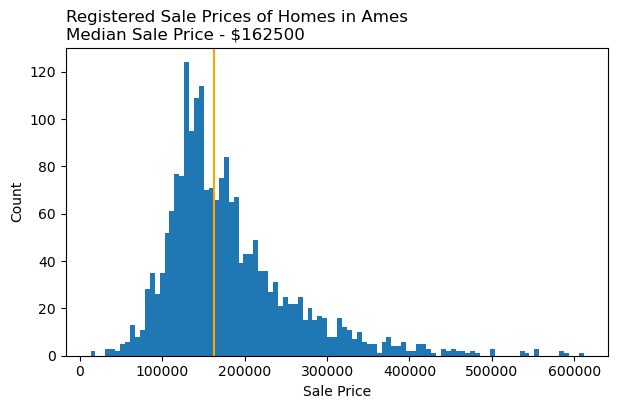

In [27]:
plt.figure(figsize=(7,4))
plt.hist(df['saleprice'], bins = 100)
plt.xlabel('Sale Price')
plt.ylabel('Count')
plt.axvline(np.median(df['saleprice']), color='orange')
plt.title('Registered Sale Prices of Homes in Ames \n'+ 
          'Median Sale Price - $162500',loc= 'left')
plt.savefig('../images/price_hist.png');

In [28]:
df.corr()['saleprice'].sort_values(ascending=False).head(20)

saleprice        1.000000
overallqual      0.803462
grlivarea        0.719463
totalbsmtsf      0.664819
garagearea       0.655483
garagecars       0.648667
1stflrsf         0.648252
yearbuilt        0.572405
yearremod/add    0.550872
fullbath         0.538225
garageyrblt      0.534514
masvnrarea       0.520023
totrmsabvgrd     0.509775
fireplaces       0.473783
bsmtfinsf1       0.445764
lotfrontage      0.355530
openporchsf      0.338545
wooddecksf       0.327629
lotarea          0.303744
bsmtfullbath     0.284763
Name: saleprice, dtype: float64

In [29]:
df.corr()['overallqual'].sort_values(ascending=False).head(20)

overallqual      1.000000
saleprice        0.803462
yearbuilt        0.602376
garagecars       0.587417
yearremod/add    0.584080
garageyrblt      0.573909
grlivarea        0.564933
garagearea       0.559804
totalbsmtsf      0.552397
fullbath         0.515052
1stflrsf         0.474783
masvnrarea       0.432345
fireplaces       0.384147
totrmsabvgrd     0.375268
openporchsf      0.300504
bsmtunfsf        0.275625
halfbath         0.272717
bsmtfinsf1       0.266829
wooddecksf       0.252890
2ndflrsf         0.228222
Name: overallqual, dtype: float64

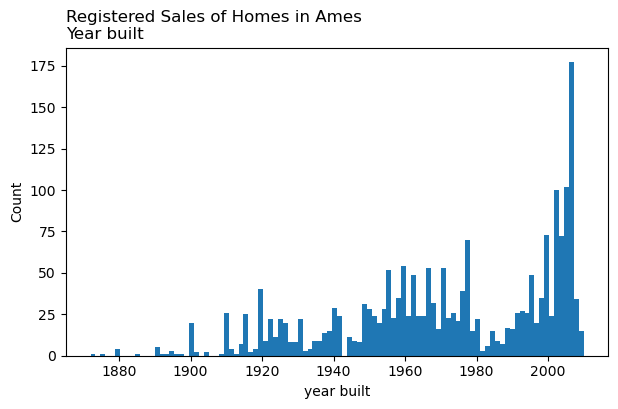

In [30]:
plt.figure(figsize=(7,4))
plt.hist(df['yearbuilt'], bins = 100)
plt.xlabel('year built')
plt.ylabel('Count')
# plt.axvline(np.mean(df['year_built']), color='orange')
plt.title('Registered Sales of Homes in Ames \n'+ 
           'Year built',loc= 'left')
plt.savefig('../images/year_built_hist.png');

Oversupply of new houses near spiked just around 2008 - thats unfortunate and may explain the sale prices of the giants - they are forclosures that would cost too much too upkeep 

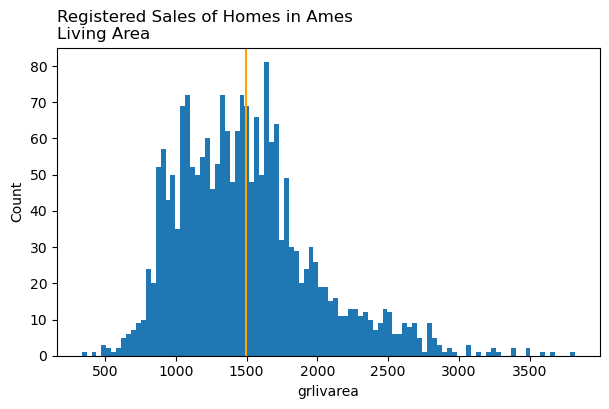

In [31]:
plt.figure(figsize=(7,4))
plt.hist(df['grlivarea'], bins = 100)
plt.xlabel('grlivarea')
plt.ylabel('Count')
plt.axvline(np.mean(df['grlivarea']), color='orange')
plt.title('Registered Sales of Homes in Ames \n'+ 
           'Living Area',loc= 'left')
plt.savefig('../images/gr_liv_area_hist.png');

#### Next, I will map, clean missing data, make dummy columns, and prepare for feature engineering 
In map_home()map the 'quality' columns to make them ordinal, which is then used to add a quality multiplier to the various types of amenities described in the data. A simple reason for why is this: A garage should increase your house's value if it is in good condition. If it is in disrepair it is a burden and its presence should decrease the sale price. This and other valuation of amenity problems are addressed in the functions I created for this


In numeric_houses() I clean the missing values from numeric columns.


In dummy_houses() I one-hot-encode the categorical variables to create columns that indicate the presence or absence of specific amenities of the property (misc_feature_Shed or misc_feature_TenC for example)


In [32]:
# lets make a function to clean the data
def clean_data(df):
    df1 = map_home(df)
    df2 = numeric_houses(df1)
    df3 = dummy_houses(df2)
    df_multplied = quality_multiplication(df3)
    return df_multplied

In [33]:
df_multplied = clean_data(df)

In [34]:
# train test split
X = df_multplied.drop('saleprice', axis=1)
y = df_multplied['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)

In [35]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1536, 321), (513, 321), (1536,), (513,))

Parameters were from gridsearching 

In [36]:
gb_params = {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300}
xgb_params = {'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 300,
 'subsample': 0.9}
rf_params = {'n_estimators': 300,}

#### I made the model training, generating predictions, and calculating error into functions for ease

In [37]:
# I need the models and parameters to use this
def train_models(models, X_train, y_train):
    trained_models = []
    for model in models:
        model_instance = model
        model_instance.fit(X_train, y_train)
        trained_models.append(model_instance)
    return trained_models

def aggregate_predictions(models, X):
    preds_all = pd.DataFrame()
    for model in models:
        preds = model.predict(X)
        preds_model = pd.DataFrame(preds, columns=[str(model).split('(')[0]+'_preds'])
        preds_all = pd.concat([preds_all, preds_model], axis=1)
    return preds_all

def create_error_dataframe(models, X_train, y_train, X_test, y_test):
    metrics_dict = {
        'Model': [],
        'RMSLE_train': [],
        'RMSLE': [],
        'RMSE_train': [],
        'RMSE': [],
        'MAE_train': [],
        'MAE': []
    }
    for model in models:
        model_name = str(model).split('(')[0]
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        
        metrics_dict['Model'].append(model_name)
        metrics_dict['RMSLE'].append(test_rmsle)
        metrics_dict['RMSE'].append(test_rmse)
        metrics_dict['MAE'].append(test_mae)
        metrics_dict['RMSLE_train'].append(train_rmsle)
        metrics_dict['RMSE_train'].append(train_rmse)
        metrics_dict['MAE_train'].append(train_mae)
        
    
    error_df = pd.DataFrame(metrics_dict)
    error_df.set_index('Model', inplace=True)
    return error_df

In [38]:
# make model list
models = [RandomForestRegressor(**rf_params), GradientBoostingRegressor(**gb_params), xgb.XGBRegressor(**xgb_params)]
# train models
trained_models = train_models(models, X_train, y_train)
# make predictions
preds_all = aggregate_predictions(trained_models, X_test)
# create error dataframe
error_df = create_error_dataframe(trained_models, X_train, y_train, X_test, y_test)

In [39]:
error_df

,RMSLE_train,RMSLE,RMSE_train,RMSE,MAE_train,MAE
Model,,,,,,
RandomForestRegressor,0.060666,0.141425,9118.443556,27394.818200,5888.219571,16235.652072
GradientBoostingRegressor,0.047217,0.126767,6087.231099,24017.092917,4776.718276,14433.171276
XGBRegressor,0.048126,0.123909,6183.122362,22338.707218,4709.582100,13608.743254


how much did my quality multiplication help? Lets compare this to the same models without the quality multiplication

In [40]:
# lets make a function to clean the data but without the quality multiplication
def clean_data_simpler(df):
    df1 = map_home(df)
    df2 = numeric_houses(df1)
    df3 = dummy_houses(df2)
    return df3

In [41]:
df_simpler = clean_data_simpler(df)

In [42]:
# train test split
X = df_simpler.drop('saleprice', axis=1)
y = df_simpler['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)

In [43]:
# make model list
models = [RandomForestRegressor(**rf_params), GradientBoostingRegressor(**gb_params), xgb.XGBRegressor(**xgb_params)]
# train models
trained_models_without = train_models(models, X_train, y_train)
# make predictions
preds_all_without = aggregate_predictions(trained_models_without, X_test)
# create error dataframe
error_df_without = create_error_dataframe(trained_models_without, X_train, y_train, X_test, y_test)


In [44]:
error_df_without

,RMSLE_train,RMSLE,RMSE_train,RMSE,MAE_train,MAE
Model,,,,,,
RandomForestRegressor,0.062369,0.142036,9249.860716,27699.211518,5982.240258,16272.678139
GradientBoostingRegressor,0.045069,0.126203,6015.344727,24221.852892,4736.318438,14573.985839
XGBRegressor,0.046428,0.124663,5942.473948,22795.657581,4490.070833,14106.729144


### voting regressor

In [45]:
# I need to make a list of the models and their parameters
models = [RandomForestRegressor(**rf_params), GradientBoostingRegressor(**gb_params), xgb.XGBRegressor(**xgb_params), DecisionTreeRegressor()]
# Define individual regressors
reg1 = RandomForestRegressor(**rf_params)
reg2 = GradientBoostingRegressor(**gb_params)
reg3 = xgb.XGBRegressor(**xgb_params)
# Define a voting regressor
voting_regressor = VotingRegressor([('rf', reg1), ('gb', reg2), ('xgb', reg3)])
# don't forget to train test split the not engineered data
X = df_multplied.drop('saleprice', axis=1)
y = df_multplied['saleprice']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=512)
# Train the ensemble regressor on the training data
voting_regressor.fit(X_train, y_train)
# Evaluate MSE, RMSE, MAE
y_pred = voting_regressor.predict(X_test)
print("RMSLE of voting regressor: ", np.sqrt(mean_squared_log_error(y_test, y_pred)))
print("RMSE of voting regressor: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE of voting regressor: ", mean_absolute_error(y_test, y_pred))

RMSLE of voting regressor:  0.1254241899924649
RMSE of voting regressor:  23844.619507270632
MAE of voting regressor:  14157.783397445517


I honestly am not sure which would work better - the voting regressor is has higher training scores (less over-fit) than my xgb model while keeping the testing scores low. Will the voting regressor do better on unseen data? I will determine that for the Kaggle submission

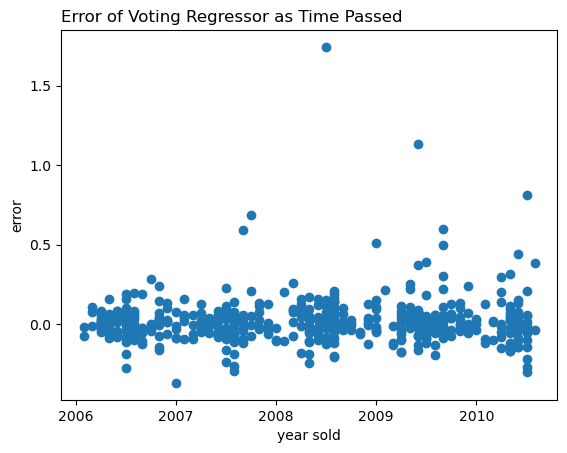

In [46]:
# How did the voting regressor do as time passed? Can we see error as a function of time graphed?
error = (y_pred-y_test)/y_test
# X_test['year_sold']
plt.scatter(X_test['year_sold'], error)
plt.xlabel('year sold')
plt.ylabel('error')
plt.title('Error of Voting Regressor as Time Passed', loc='left')
plt.savefig('../images/error_over_time.png');

In [47]:
error.describe()

count    513.000000
mean       0.015083
std        0.150948
min       -0.371485
25%       -0.049611
50%       -0.002126
75%        0.055143
max        1.744657
Name: saleprice, dtype: float64

50% of my predictions are within 5% of the real sale price. The max represents a house that was predicted to be sold at 1.7 times more than the price it was acutally sold. This data is from right in the middle of 2008 which was a turbulent time for home values and the model seems to predict well most of the time. 

In [48]:
# generate predictions for the test data
test1 = pd.read_csv('../datasets/test1.csv')
test1.columns =test1.columns.str.lower().str.replace(' ','')


In [49]:
test_multplied = clean_data(test1)
test_resized = test_col_matcher(X_train, test_multplied)

In [50]:
# make predictions
test_preds = voting_regressor.predict(test_resized)
# turn into dataframe
submission = pd.DataFrame({'Id': test1['id'], 'SalePrice': test_preds})
submission.head()

,Id,SalePrice
0,1461,123937.900720
1,1462,168669.486347
2,1463,180318.235100
3,1464,187614.240582
4,1465,183938.110353


In [51]:
# save to csv
submission.to_csv('../datasets/submission1.csv', index=False)

In [52]:
# lets compare how the submissions scores when only using xgb! Submit to kaggle again
# train test split is not needed. I can use the same processed data as before
# define model
xgb_model = xgb.XGBRegressor(**xgb_params)
# fit model
xgb_model.fit(X_train, y_train)
# make predictions
test_preds = xgb_model.predict(test_resized)
# turn into dataframe
submission = pd.DataFrame({'Id': test1['id'], 'SalePrice': test_preds})
submission.head()
# save to csv
submission.to_csv('../datasets/submission.csv', index=False)

## Conclusion

I attempted and succeeded in developing a method to clean and prepare data to be used for training models or making predictions. My feature engineering (quality multiplication) enhanced the performance of every model, including the voting regressor.

The XGBoost (xgb) model demonstrated the best performance on the Kaggle dataset with a public score of 0.09626, while the voting regressor achieved a score of 0.09720. The data used for this analysis was collected for one city before, during, and after the housing collapse of 2008. Predicting house prices based solely on physical features is challenging, as various factors such as schools, neighbors, preferences, and negotiations also influence the sale price. In this project, the best reasonable outcome is accurate predictions the majority of the time. Calculating the error for each prediction reveals that the middle 50% of sales are within 5% of the actual sale price.

**KAGGLE SUBMISSION:** Ranked in the top 2% of scores on the [House Prices: Advanced Regression Techniques Kaggle Leaderboard](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/leaderboard) with a score of 0.09626, placing 89th out of 4219 as of Jan 16, 2024 (the voting regressor performed comparably but slightly worse at 0.0972).
